In [2]:
import scipy
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import math 
import modred as mr
from scipy.linalg import eig
import pysindy as ps
from scipy.signal import savgol_filter
from scipy.io import loadmat
#scipy.__version__

/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Selecting the simulation data according to Wi range

#in_filename2 = "M1_4R_wi4_4.2_4.35_4.5_260_t_460.npz" # u,v,B
#in_filename2 = "M1_4R_wi6_6.5_6.75_7_200_t_300.npz" # u,v,B
#in_filename2 = "M1_4R_wi5_5.5_6_6.5_200_t_300.npz" # u,v,B
in_filename2 = "M1_16R_3.6_3.8_4_320_t_400.npz" # u,v,B

Matrix = np.load(in_filename2, allow_pickle=True)["Matrix"]
M = Matrix
M_mean = M.mean(1).reshape(-1,1)
Mn = M  -  M_mean# subtracting off the mean in time
Mn2 = Mn.T@Mn

In [4]:
# snapshots method
eM,QM = np.linalg.eig(Mn2)
eM = np.real(eM) 
QM = np.real(QM) 
eM[eM<0] = 0 


In [5]:
# ORDERING eigenvalues/eigenvectors
idx = np.argsort(-eM) 
eM = eM[idx] 
QM = QM[:,idx] 
EM = np.diag(1/np.sqrt(eM)) 
SigmaM = np.diag(np.sqrt(eM)) 


/var/folders/2z/3cfggdrs7xl2wpmkpt9r1wgm0000gn/T/ipykernel_1905/673226342.py:5: RuntimeWarning: divide by zero encountered in divide
  EM = np.diag(1/np.sqrt(eM))


In [8]:
# preparing matrix data to seed SINDy
cM = np.arange(QM.shape[1]).reshape(-1,1)
QQM = np.concatenate((cM,QM),1)
np.save("16-roll_parametric.npy",QQM)    
AvhM = np.load("16-roll_parametric.npy")
tM = AvhM[:, 0]
AvhM = AvhM[:,1:]


In [10]:
active_idx = [0, 1]  # Dynamically active modes
# first two POD modes
r = 2
tfrac = 0.8  # Proportion of the data to train on
M = len(tM)
M_train = int(len(tM) * tfrac)
t_train = tM[:M_train]
t_test = tM[M_train:]
pod_names = ["a{}".format(i) for i in (active_idx)]

# Normalize the trajectories for simplicity
normalizationM = sum(np.amax(abs(AvhM), axis=0)[active_idx])
xM = np.zeros((AvhM.shape[0], r))
xM[:, 0] = AvhM[:, 0] / normalizationM
xM[:, 1] = AvhM[:, 1] / normalizationM
initial_guess = np.zeros((r,6))  # manual

x_trainM = xM[:M_train, :]

x0_trainM = xM[0, :]
x_testM = xM[M_train:, :]
x0_testM = xM[M_train, :]


In [11]:
# This stage is dedicted to construct the training and test dataset according to Wi number
X = []
U = []
nw = 3
Nt = 800
M_train = 800
#ws = [4.0, 4.2, 4.35, 4.5, 5.0]
#ws = [7.0, 8.0, 9.0, 10.0]
#ws = [6.0, 6.5, 6.75, 7.0]
ws = [3.6, 3.8, 4.0]

for i in range(nw):
    #print(i*Nt,(i*Nt)+M_train)
    X.append(xM[i*Nt:(i*Nt)+M_train,:])
    U.append(np.repeat(1/ws[i],M_train).reshape(-1,1))

In [12]:
# This stage is dedicted to construct the training and test dataset according to Wi number

X_train = [X[0], X[2]]
U_train = [U[0], U[2]]

X_test = [X[1]]
U_test = [U[1]]

ws_train = [3.6,4.0]
ws_test = [3.8]

nw_train = 2
nw_test = 1
Nt = 800
M_train = 800



In [13]:
# We select linear and cubic terms for the candidate library in SINDy

sindy_opt = ps.SR3(
    threshold=0.0001, nu=1, max_iter=1000)

library_functions = [lambda x:x, 
                             lambda x, y, z: x * y * z, lambda x, y: x ** 2 * y,
                             lambda x, y: x * y ** 2, lambda x: x ** 3]
library_function_names = [lambda x:x, 
                                  lambda x, y, z: x + y + z, lambda x, y: x + x + y,
                                  lambda x, y: x + y + y, lambda x: x + x + x]

sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)


model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=['a0','a1','w'],
)

#model.fit(x = X, t=t[:M_train], u = U, multiple_trajectories=True)
model.fit(x = X_train, t=tM[:M_train], u = U_train, multiple_trajectories=True)

SINDy(differentiation_method=FiniteDifference(drop_endpoints=True),
      feature_library=<pysindy.feature_library.custom_library.CustomLibrary object at 0x13ecc5b70>,
      feature_names=['a0', 'a1', 'w'],
      optimizer=SR3(max_iter=1000, nu=1, threshold=0.0001))

In [14]:
model.print()

(a0)' = 0.037 a0 + 0.083 a1 + -0.001 w + 0.013 a0a1w + -0.043 a0a0a1 + -0.001 a0a0w + 0.012 a1a1w + -0.134 a0a1a1 + -0.364 a0ww + -0.548 a1ww + -0.043 a0a0a0 + -0.102 a1a1a1 + -0.003 www
(a1)' = -0.083 a0 + 0.037 a1 + -0.003 w + 0.010 a0a1w + -0.136 a0a0a1 + 0.004 a0a0w + 0.014 a1a1w + 0.042 a0a1a1 + 0.547 a0ww + -0.366 a1ww + 0.104 a0a0a0 + -0.043 a1a1a1 + 0.040 www


In [15]:
# preparing the time interval for testing
t_test_full = np.arange(0,800,1)
init_time = 0
index = 0
pred = model.simulate(X_test[index][init_time], t_test_full[init_time:], u=U_test[index][init_time:])

/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/pysindy-1.7.3.dev4+gdfbe7f3.d20230113-py3.10.egg/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.


In [18]:
# preparing data to construct the expression for the third mode as function of the first two modes
xM3 = AvhM[:, 2] / normalizationM

A12 = []
A3 = []
U3 = []
#ws2 = [4.0, 4.35, 4.5]

for i in range(len(ws)):
    pred = model.simulate(X[i][init_time], t_test_full[init_time:], u=U[i][init_time:])
    A12.append(pred)
    A3.append(xM3[i*Nt:(i*Nt)+M_train-1].reshape(-1,1))
    U3.append(U[i][:-1].reshape(-1,1))

/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/pysindy-1.7.3.dev4+gdfbe7f3.d20230113-py3.10.egg/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/pysindy-1.7.3.dev4+gdfbe7f3.d20230113-py3.10.egg/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/pysindy-1.7.3.dev4+gdfbe7f3.d20230113-py3.10.egg/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.


In [19]:
A3_train = [A3[0], A3[2]]
A12_train = [A12[0], A12[2]]
U3_train = [U3[0], U3[2]]

A3_test = [A3[1]]
A12_test = [A12[1]]
U3_test = [U3[1]]


In [20]:
# Using quadratic terms, we construct expressions for the third mode
sindy_opt = ps.SR3(
    threshold=0.00001, nu=1, max_iter=1000)

library_functions = [lambda x, y:x * y, lambda x:x ** 2]#
library_function_names = [lambda x, y:x + y, lambda x:x + x]


sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)


model2 = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=['a0','a1','w'],
)



# Fit a model on the training data
model2.fit(x = A12_train, x_dot = A3_train , multiple_trajectories=True) #u = U3_train, 

model2.print()
model2.coefficients()

(a0)' = 3.064 a0a1 + 1.930 a0a0 + -1.930 a1a1


array([[ 3.06427391,  1.92975993, -1.92996633]])

In [21]:
def f(a0,a1,w):
    a2 = 3.064*a0*a1 + 1.930*a0*a0 -1.930*a1*a1
    return a2

In [27]:
# predicting the third mode
pred = model.simulate(X_test[index][init_time], t_test_full[init_time:], u=U[1][init_time:])
a0M = pred[:,0]
a1M = pred[:,1]

a2M = f(a0M,a1M,0.23809523809523808) # 1/ Wi = 0.23809523809523808



/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/pysindy-1.7.3.dev4+gdfbe7f3.d20230113-py3.10.egg/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.


In [28]:
# preparing data to construct the expression for the fourth mode as function of the first two modes
xM4 = AvhM[:, 3] / normalizationM
A12 = []
A4 = []
U4 = []

for i in range(len(ws)):
    pred = model.simulate(X[i][init_time], t_test_full[init_time:], u=U[i][init_time:])
    A12.append(pred)
    A4.append(xM4[i*Nt:(i*Nt)+M_train-1].reshape(-1,1))
    U4.append(U[i][:-1].reshape(-1,1))

/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/pysindy-1.7.3.dev4+gdfbe7f3.d20230113-py3.10.egg/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/pysindy-1.7.3.dev4+gdfbe7f3.d20230113-py3.10.egg/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/pysindy-1.7.3.dev4+gdfbe7f3.d20230113-py3.10.egg/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.


In [29]:


A4_train = [A4[0], A4[2]]
A12_train = [A12[0], A12[2]]
U4_train = [U4[0], U4[2]]

A4_test = [A4[1]]
A12_test = [A12[1]]
U4_test = [U4[1]]



In [30]:
# Using quadratic terms, we construct expressions for the fourth mode

sindy_opt = ps.SR3(
    threshold=0.00001, nu=1, max_iter=1000)

library_functions = [lambda x, y:x * y, lambda x:x ** 2]#
library_function_names = [lambda x, y:x + y, lambda x:x + x]


sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)


model3 = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=['a0','a1','w'],
)



# Fit a model on the training data
model3.fit(x = A12_train, x_dot = A4_train , multiple_trajectories=True) #u = U3_train, 

model3.print()
model3.coefficients()

(a0)' = -3.907 a0a1 + 1.040 a0a0 + -1.020 a1a1


array([[-3.90738931,  1.04021906, -1.02025083]])

In [31]:
def f2(a0,a1,w):
    a3 = -3.907*a0*a1 + 1.040*a0*a0  -1.020*a1*a1

    return a3

In [32]:
# predicting the fourth mode

pred = model.simulate(X_test[index][init_time], t_test_full[init_time:], u=U[1][init_time:])
a0M = pred[:,0]
a1M = pred[:,1]

a3M = f2(a0M,a1M,0.23809523809523808) # 1/ Wi = 0.23809523809523808
#a2M = f(A12[2][:,0],A12[2][:,1],0.22988506)
#print(a3M)


/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/pysindy-1.7.3.dev4+gdfbe7f3.d20230113-py3.10.egg/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.


(array([], dtype=float64), [])

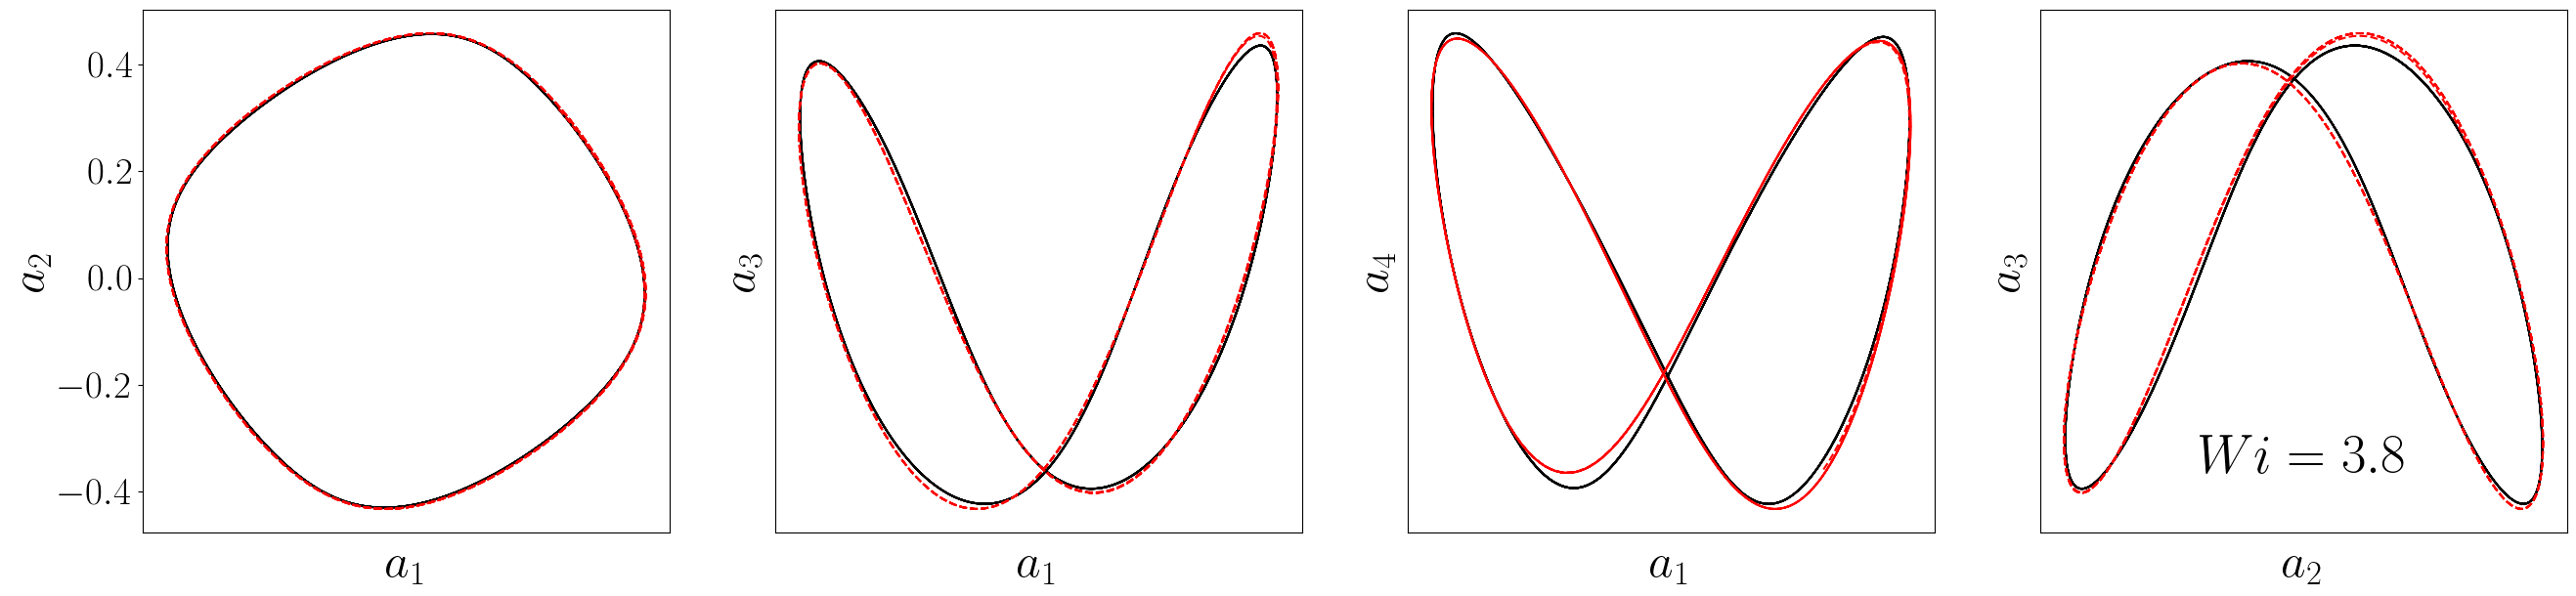

In [33]:

fig = plt.figure(figsize=(32,32))
plt.rcParams['text.usetex'] = True
ax = fig.add_subplot(441)
plt.plot(X_test[index][:,0],X_test[index][:,1],'black',label="Data")
plt.plot(pred[:,0],pred[:,1],'r--',label="SINDy")
plt.xlabel('$a_1$', fontsize=36)
plt.ylabel('$a_2$', fontsize=36)
plt.xticks([])
#plt.yticks([])
plt.yticks(fontsize=28)
plt.xticks(fontsize=28)
#plt.legend(fontsize=40)

ax = fig.add_subplot(442)
plt.plot(X_test[index][:799,0],A3[1],'black',label="Data")
plt.plot(pred[:,0],a2M,'r--',label="SINDy")#plt.xticks([])
plt.yticks([])
plt.xlabel('$a_1$', fontsize=36)
plt.ylabel('$a_3$', fontsize=36)
plt.xticks([])
plt.yticks([])
#plt.yticks(fontsize=22)
plt.xticks(fontsize=28)
#plt.legend(fontsize=18)

ax = fig.add_subplot(443)
plt.plot(X_test[index][:799,0],A4[1],'black',label="Data")
plt.plot(pred[:,0],a3M,'r--',label="SINDy")#plt.xticks([])
#plt.xticks(fontsize=36)
plt.yticks([])
plt.xticks([])
plt.xlabel('$a_1$', fontsize=36)
plt.ylabel('$a_4$', fontsize=36)
#plt.yticks(fontsize=22)
plt.xticks(fontsize=28)


ax = fig.add_subplot(444)
plt.plot(X_test[index][:799,1],A3[1],'black',label="Data")
plt.plot(pred[:,1],a2M,'r--',label="SINDy")#plt.xticks([])
plt.xticks([])
plt.yticks([])
plt.xlabel('$a_2$', fontsize=36)
plt.ylabel('$a_3$', fontsize=36)
#ax2 = ax.twinx()
#plt.ylabel(r'$testing$', fontsize=40)
#plt.yticks([])
ax.set_title(r'$Wi = 3.8$', y=0.15, pad=-14, fontsize=40)
#plt.yticks(fontsize=32)
plt.xticks(fontsize=28)
#plt.legend()

In [34]:
### reconstruction from the predicted modes: we have fixed the time
#Tr = M_mean.reshape((3,64,64)) 
Tr = M_mean.reshape((3,128,128)) 
Tnn =  Mn[:,:]  
Tn1 = Tnn[:,798].reshape((3,Tr.shape[1],Tr.shape[2])) 
Tn1 = np.moveaxis(Tn1, [0], [-1])
trace_A = (Tn1[:,:,0]*Tn1[:,:,0])+(Tn1[:,:,2]*Tn1[:,:,2])+(2*(Tn1[:,:,1]*Tn1[:,:,1]))


In [36]:
TnnA =  Mn[:,:] + M_mean


In [37]:
## normalization for reconstruction
pred_norm = pred*normalizationM
a2M = a2M.reshape((799,-1)) 
a2M_norm = a2M*normalizationM
pred_norm = np.concatenate([pred_norm, a2M_norm],1)
a3M = a3M.reshape((799,-1)) 
a3M_norm = a3M*normalizationM
pred_norm = np.concatenate([pred_norm, a3M_norm],1)


In [38]:
# reconstruction SINDy
QM =  QM[:,:]
phii  = Tnn@QM[:,:]@EM[:,:] # constructing the spatial modes from Method of snapshots
ErM = EM[:4,:4] # first r components of diagonal matrix E
SigmarM = SigmaM[:4,:4] # first r components
ErMinv = linalg.inv(ErM)
Xsindy = phii[:,:4]@SigmarM@pred_norm.T
Xsindy1 = Xsindy[:,798].reshape((3,Tr.shape[1],Tr.shape[2])) 
Xsindy1 = np.moveaxis(Xsindy1, [0], [-1])
trace_A_SINDy = (Xsindy1[:,:,0]*Xsindy1[:,:,0])+(Xsindy1[:,:,2]*Xsindy1[:,:,2])+(2*(Xsindy1[:,:,1]*Xsindy1[:,:,1]))

# computing the errors
error = np.abs(trace_A-trace_A_SINDy)/np.linalg.norm(trace_A)
error1 = np.abs(Tn1[:,:,0]-Xsindy1[:,:,0])/np.linalg.norm(Tn1[:,:,0])
error2 = np.abs(Tn1[:,:,1]-Xsindy1[:,:,1])/np.linalg.norm(Tn1[:,:,1])
error3 = np.abs(Tn1[:,:,2]-Xsindy1[:,:,2])/np.linalg.norm(Tn1[:,:,2])




In [39]:
XsindyA = Xsindy[:,:] + M_mean


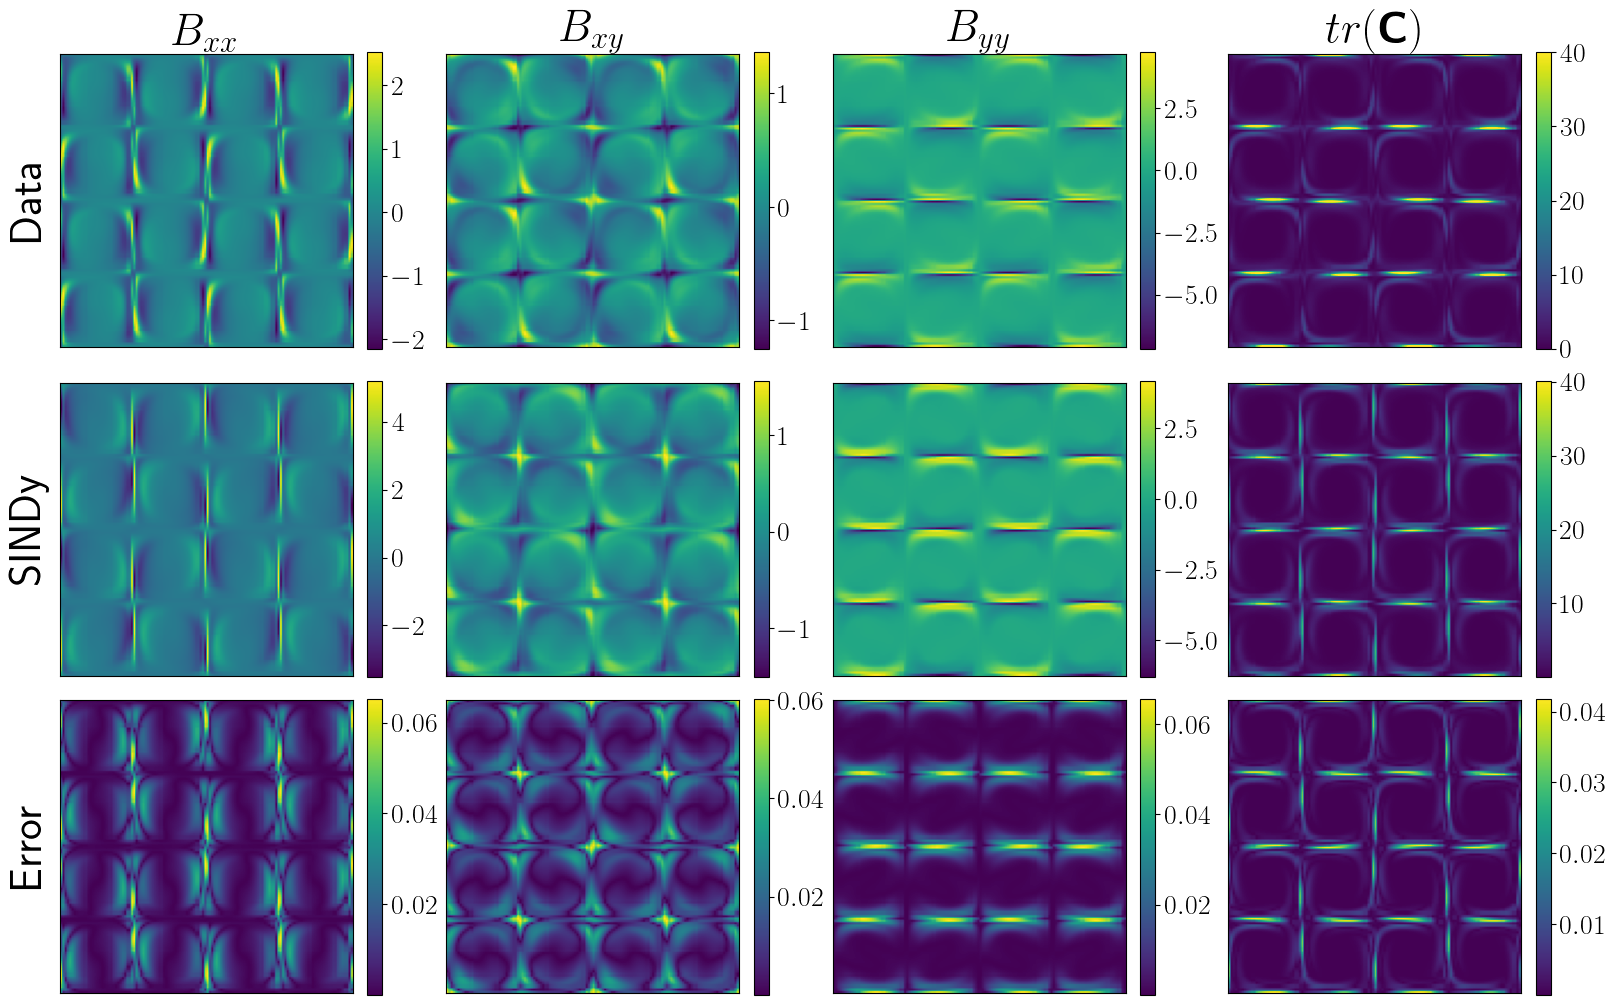

In [40]:
fig = plt.figure(figsize=(16,10),constrained_layout=True)
plt.rcParams['text.usetex'] = True
ax = plt.subplot2grid((3,4), (0,0), rowspan=1, colspan=1)
surf = ax.imshow(Tn1[:,:,0])
#plt.colorbar(surf)
plt.title('$B_{xx}$',fontsize=32)
plt.ylabel(r'Data',fontsize=32)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (0,1), rowspan=1, colspan=1)
surf = ax.imshow(Tn1[:,:,1])
#plt.colorbar(surf)
plt.title('$B_{xy}$',fontsize=32)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (0,2), rowspan=1, colspan=1)
surf = ax.imshow(Tn1[:,:,2])
#plt.colorbar(surf)
plt.title('$B_{yy}$',fontsize=32)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (0,3), rowspan=1, colspan=1)
surf = ax.imshow(trace_A)
plt.title(r'$tr(\textbf{C})$',fontsize=32)
#plt.xlabel('snapshots')
plt.xticks([])
plt.yticks([])
surf.set_clim(0,40)
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (1,0), rowspan=1, colspan=1)
surf = ax.imshow(Xsindy1[:,:,0])
#plt.colorbar(surf)
#plt.title('$B_{xx}$')
plt.ylabel(r'SINDy',fontsize=32)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)


ax = plt.subplot2grid((3,4), (1,1), rowspan=1, colspan=1)
surf = ax.imshow(Xsindy1[:,:,1])
#plt.colorbar(surf)
#plt.title('$B_{xy}$')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (1,2), rowspan=1, colspan=1)
surf = ax.imshow(Xsindy1[:,:,2])
#plt.colorbar(surf)
#plt.title('$B_{yy}$')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (1,3), rowspan=1, colspan=1)
surf = ax.imshow(trace_A_SINDy)
#plt.title(r'$a_2$',fontsize=22)
#plt.xlabel('snapshots')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)


ax = plt.subplot2grid((3,4), (2,0), rowspan=1, colspan=1)
surf = ax.imshow(error1)
#plt.colorbar(surf)
#plt.title('$B_{xx}$')
plt.ylabel(r'Error',fontsize=32)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)


ax = plt.subplot2grid((3,4), (2,1), rowspan=1, colspan=1)
surf = ax.imshow(error2)
#plt.colorbar(surf)
#plt.title('$B_{xy}$')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (2,2), rowspan=1, colspan=1)
surf = ax.imshow(error3)
#plt.colorbar(surf)
#plt.title('$B_{yy}$')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (2,3), rowspan=1, colspan=1)
surf = ax.imshow(error)
#plt.title(r'$a_3$',fontsize=22)
#plt.xlabel('snapshots')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)